In [0]:
# Set up the mount of the google drive.
!pip install librosa
import librosa
from google.colab import drive
drive.mount('/content/drive')

# Set up the path to the customized module.
import sys
sys.path.append('/content/drive/My Drive/CSCE 666/Project/Workspace') # where the lpc.py located.
from lpc import lpc
#from audioclass import AudioWav
#from audioclass import RespiratoryCycle
class AudioWav:
    def __init__(self, filename, data, rate):
        self.filename = filename
        self.data = data # a numpy array
        self.rate = rate # sample rate

class RespiratoryCycle:
    def __init__(self, filename, begin, end, crackleFLag, wheezeFlag, data, rate):
        self.filename = filename
        self.begin = begin
        self.end = end
        self.crackleFLag = crackleFLag
        self.wheezeFlag = wheezeFlag
        self.data = data # cropped numpy array
        self.rate = rate




Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Find all wav files.
import glob
wavNameList = [f.split('.wav')[0] for f in glob.glob("/content/drive/My Drive/CSCE 666/Project/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/*.wav")]

# Read in wav data (920).
wavList = [];
for i in range(len(wavNameList)):
    print(str(i), end=" ")
    wavName = wavNameList[i]
    data, rate = librosa.load(wavName + ".wav")
    ind = wavName.rfind('/')
    wavfileName = wavName[ind+1:]
    wavList.append( AudioWav(wavfileName, data, rate) )
print("\nDone reading wav files")

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [0]:
# Obtain all respiratory cycles (6898).
import math
RCList = []
for i in range(len(wavNameList)):
    wavTxtFile = open(wavNameList[i] + ".txt", "r");
    wavData, wavRate = wavList[i].data, wavList[i].rate
    for RCTxt in wavTxtFile:
        RC = RCTxt.split("\t");
        begin, end = float(RC[0]), float(RC[1])
        beginInd = math.floor(begin*wavRate)
        endInd = math.ceil(end*wavRate)
        RCData = wavData[beginInd:endInd]
        filename = wavList[i].filename
        RCList.append( RespiratoryCycle(filename, float(RC[0]), float(RC[1]), int(RC[2]), int(RC[3]), RCData, wavRate) )
print("Done obtaining all respiratory cycles")

Done obtaining all respiratory cycles


In [0]:
# Perform LPC with order 2 on wavList and RCList.
order = 2

wavLpcs = [[0 for x in range(order+1)] for y in range(len(wavList))];
for i in range(len(wavList)):
    y, rate = wavList[i].data, wavList[i].rate
    a = lpc(y, order)
    wavLpcs[i] = list(x for x in a)

RCLpcs = [[0 for x in range(order+1)] for y in range(len(RCList))];
for i in range(len(RCList)):
    y, rate = RCList[i].data, RCList[i].rate
    a = lpc(y, order)
    RCLpcs[i] = list(x for x in a)

In [0]:
# Save lpcs into csv files.
import pandas as pd

pd.DataFrame(wavLpcs).to_csv("/content/drive/My Drive/CSCE 666/Project/Feature/LPC/wav-lpc.csv", header=None, index=None)
pd.DataFrame(RCLpcs).to_csv("/content/drive/My Drive/CSCE 666/Project/Feature/LPC/RC-lpc.csv", header=None, index=None)


<class 'numpy.ndarray'>
<class 'tuple'>
12
[0.498042   0.498042   0.498042   ... 0.11234779 0.11234779 0.11234779]
10344


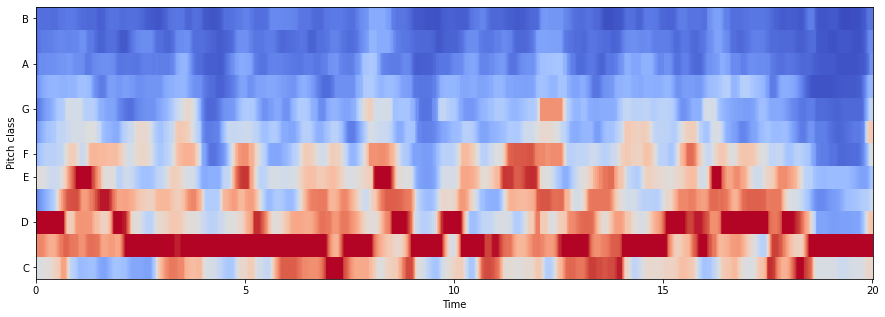

In [0]:
# https://musicinformationretrieval.com/chroma.html
# https://librosa.github.io/librosa/auto_examples/plot_chroma.html
from matplotlib import pyplot as plt
import librosa.display
import scipy
import numpy as np

y, rate = wavList[0].data, wavList[0].rate
hop_length = 512
chroma_os = librosa.feature.chroma_cqt(y=y, sr=rate, hop_length=hop_length)
y_harm = librosa.effects.harmonic(y=y, margin=8)
chroma_os_harm = librosa.feature.chroma_cqt(y=y_harm, sr=rate, bins_per_octave=12*3)
chroma_filter = np.minimum(chroma_os_harm, librosa.decompose.nn_filter(chroma_os_harm, aggregate=np.median, metric='cosine'))
chroma_smooth = scipy.ndimage.median_filter(chroma_filter, size=(1, 9))
print(type(chroma_smooth))
print(type(chroma_smooth.shape))
print(chroma_smooth.shape[0])
plt.figure(figsize=(15, 5))
librosa.display.specshow(chroma_smooth, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

import csv
with open('/content/drive/My Drive/CSCE 666/Project/test.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    row_vec = []
    chroma_smooth_reshape = chroma_smooth.reshape(1, chroma_smooth.size)
    print(chroma_smooth_reshape[0])
    row_vec = list(x for x in chroma_smooth_reshape[0])
    print(len(row_vec))
    writer.writerow(row_vec)

In [0]:
# Write respiratory cycles information into csv file.
import csv
with open('/content/drive/My Drive/CSCE 666/Project/Feature/RC.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Id", "Filename", "Begin", "End", "Crackle", "Wheeze"])
    for i in range(len(RCList)):
      writer.writerow([str(i+1), RCList[i].filename, RCList[i].begin, RCList[i].end, RCList[i].crackleFLag, RCList[i].wheezeFlag])


In [0]:
# Save chrome-smooth feature of each wav data.
import numpy as np
import scipy
import csv
with open('/content/drive/My Drive/CSCE 666/Project/Feature/Chroma-smooth/Wav/wav-chroma-smooth.csv', 'w', newline='') as file:
  writer = csv.writer(file)
  for i in range(len(wavList)):
    y = wavList[i].data
    y_harm = librosa.effects.harmonic(y=y, margin=8)
    chroma_os_harm = librosa.feature.chroma_cqt(y=y_harm, sr=rate, bins_per_octave=12*3)
    chroma_filter = np.minimum(chroma_os_harm, librosa.decompose.nn_filter(chroma_os_harm, aggregate=np.median, metric='cosine'))
    chroma_smooth = scipy.ndimage.median_filter(chroma_filter, size=(1, 9))
    chroma_smooth_reshape = chroma_smooth.reshape(1, chroma_smooth.size);
    row_vec = list(x for x in chroma_smooth_reshape[0])
    writer.writerow(row_vec)
    #pd.DataFrame(chroma_smooth).to_csv("/content/drive/My Drive/CSCE 666/Project/Feature/Chroma-smooth/Wav/"+wavList[i].filename+".csv", header=None, index=None)



/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequen

In [0]:
# Save chrome-smooth feature of each wav and RC data.
with open('/content/drive/My Drive/CSCE 666/Project/Feature/Chroma-smooth/RC/RC-chroma-smooth.csv', 'w', newline='') as file:
  writer = csv.writer(file)
  for i in range(len(RCList)):
    print(i, end = ",")
    y = RCList[i].data
    y_harm = librosa.effects.harmonic(y=y, margin=8)
    chroma_os_harm = librosa.feature.chroma_cqt(y=y_harm, sr=rate, bins_per_octave=12*3)
    chroma_filter = np.minimum(chroma_os_harm, librosa.decompose.nn_filter(chroma_os_harm, aggregate=np.median, metric='cosine'))
    chroma_smooth = scipy.ndimage.median_filter(chroma_filter, size=(1, 9))
    chroma_smooth_reshape = chroma_smooth.reshape(1, chroma_smooth.size);
    row_vec = list(x for x in chroma_smooth_reshape[0])
    writer.writerow(row_vec)
  #pd.DataFrame(chroma_smooth).to_csv("/content/drive/My Drive/CSCE 666/Project/Feature/Chroma-smooth/RC/"+str(i+1)+".csv", header=None, index=None)
print("\n Done")